Machine Learning competition testing some stuff out


In [1]:
# PATHS
DATA_DIR = 'D:/Users/main/Documents/UGent/1ste Master/Machine Learning/data/data'
POSE_DIR = 'D:/Users/main/Documents/UGent/1ste Master/Machine Learning/data/data/pose'
print("Directory ready")

Directory ready


In [2]:
# First we load the main libraries we will need

# REQUIRED IMPORTS FROM STANDARD PACKAGES

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import csv
import random
import math

from os.path import join as pjoin
from glob import glob

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Normally, all libraries are loaded only once, 
# even if you execute the import code multiple times
rng = np.random.RandomState(69)
%load_ext autoreload
%autoreload 1
%aimport augmentation
%aimport features_extraction


print("Environment ready!")

Environment ready!


In [3]:
# IMPORTS FROM THE UTIL LIBRARY PROVIDED BY US

import util.submission as S
import util.vis as V
import util.metrics as M
#import util.MovementHands as MH

print('utilities ready')

utilities ready


## Step 1: problem and data analysis

The first thing we do is loading the data and, if necessary, preprocessing it into a form that is useful for machine learning. Some things you may typically have to do are:

- **Converting all data to numerical values:** some data may be in the form of textual labels. These should be converted to numerical values, using an encoding that maximally corresponds to the underlying structure of those labels. In particular, if the labels imply some kind of ordering (e.g., 'small, 'medium', 'large'), this ordering should be reflected in the values (e.g., '1', '2', '3'). If there is no such ordering, it is usually better to use an encoding that does **not** imply this, such as a one-hot encoding. You might for example convert the colours 'red', 'green', 'blue' to the vectors '(0,0,1)', '(0,1,0)', '(1,0,0)'. This effectively replaces one textual feature by three numerical features, but leaves more freedom for the model because it does not have to 'undo' an ordering in the features that was not really there to begin with
- **Correcting for missing data:** often, some features are missing for some data samples. These may be indicated as NaN, or '-' or any other non-numerical value. In order to be processed by a machine learning model, such samples can be omited (if there are few), but it is usually better to replace those values by a well-chosen numerical value. Which value makes sense depends very much on the problem at hand and the typical ranges for the feature in question.
- **Outlier removal:** generally, it is advised to be very careful with this. Keeping outliers in your data often makes the final model more robust. Remove outliers **only** when real exceptional cases occur in your data **and** they can be expected to hamper the training of your model. The question that should be asked here is whether or not you want your model to be able to deal with such cases. When your model is operational, often extreme cases could be detected upfront and treated differently (i.e., not by your model). Those are the ones you want to leave out of your data set. Any other case is best left in. You might consider to cap extreme values, by replacing them by the maximal (or minimal) value you find reasonable.

Obviously, more advanced forms of preprocessing can also be considered, such as filtering or advanced feature extraction. Those will not be discussed in this notebook.

As mentioned before, for the data set considered here, the data is already nice and clean. We only have to load it:

In [5]:
dataset_file = pjoin(DATA_DIR, 'labels.csv')

all_samples = []
all_labels = []
all_persons = []
all_personlabels = []

with open(dataset_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # Skips the first row, which is the header
    for row in reader:
        name, _gloss, label, _person = row
        sample = np.load(pjoin(POSE_DIR, 'train', name + '.npy'))
        all_samples.append(sample)
        all_labels.append(label)
        all_persons.append(_person)
        all_personlabels.append((label, _person))
        
all_labels = np.array(all_labels)
all_persons = np.array(all_persons)
#print(all_persons)
print("done")
print(len(all_samples), len(all_labels))


done
3718 3718


In [14]:
def downsample(all_samples, all_labels, all_persons):
    """
    Functions that samples down untill every label has the same amount of samples
    
    :param all_samples: all the samples that need to be sampled down
    :param all_labels: the corresponding labels with the samples    
    """
    
    tot_label_list = [0 for i in range(18)]
    for label in all_labels:
        tot_label_list[int(label)] += 1
    max_labels = min(tot_label_list)
    print(tot_label_list)
    print(max_labels)
    new_samples = []
    new_labels = []
    new_persons = []
    new_labellist = [0 for i in range(18)]
    for i in range(len(all_samples)):
        sample = all_samples[i]
        if (new_labellist[int(all_labels[i])] < max_labels):
            new_samples.append(all_samples[i])
            new_labels.append(all_labels[i])
            new_labellist[int(all_labels[i])] += 1
            new_persons.append(all_persons[i])
    return new_samples, new_labels, new_labellist, all_persons
down_samples, down_labels, down_labellist = downsample(all_samples, all_labels)
print(down_labellist)
print(len(down_samples), 18 * 125, len(down_labels))
print(down_samples[0].shape)
    

[414, 355, 240, 248, 225, 234, 214, 188, 193, 178, 182, 172, 174, 144, 144, 157, 125, 131]
125
[125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
2250 2250 2250
(10, 137, 3)


In [6]:
def angles(sample, q0, q1, key1, key2,i , shape, control = 1): #control keypoint is the neck keypoint = 1
    """
    Function that calculates the mean angle between two keypoints. The vectors used for the calculations are respective to the
    neck.
    
    :param sample: the sample that is being featured
    :param q0: begin of the quarter frame
    :param q1: end of the quarter frame
    :param key1: number of the first keypoint
    :param key2: number of the second keypoint
    :param control: the number of the keypoint that is being used to measure the angles with. this is standard set to the neck which has keypoint number 1.
    """
    special_val_angle = math.pi/180*270
    ret_list = []
    median_angles = []
    std_angles = []
    angles = np.zeros(q1 - q0)
    for j in range(q0, q1): 
        key1_vector = sample[j][key1] - sample[j][control] #get x and y value
        key2_vector = sample[j][key2] - sample[j][control] #get x and y value
        if (np.linalg.norm(key1_vector) == 0): #Catch outliers keypoint 1
            k = j-1
            while (np.linalg.norm(key1_vector) == 0 and k>=0): #previous frames
                key1_vector = sample[k][key1] - sample[k][control]
                k -=1
            if (k == -1 and np.linalg.norm(key1_vector) == 0): #future frames
                k = j+1
                while (np.linalg.norm(key1_vector) == 0 and k<len(sample)):
                    key1_vector = sample[k][key1] - sample[k][control]
                    k+=1
        if (np.linalg.norm(key2_vector) == 0): #Catch outliers keypoint 2
            k = j-1
            while (np.linalg.norm(key2_vector) == 0 and k>=0): #previous frames
                key2_vector = sample[k][key2] - sample[k][control]
                k -=1
            if (k == -1 and np.linalg.norm(key2_vector) == 0): #future frames
                k = j+1
                while (np.linalg.norm(key2_vector) == 0 and k<len(sample)):
                    key2_vector = sample[k][key2] - sample[k][control]
                    k+=1
        key1_vector = key1_vector[:2]/np.linalg.norm(key1_vector[:2])
        key2_vector = key2_vector[:2]/np.linalg.norm(key2_vector[:2])
        angle = np.arccos(np.clip(np.dot(key1_vector, key2_vector), -1.0, 1.0))
        angles[j-q0] = angle
    if math.isnan(np.median(angles)):
        ret_list.append(special_val_angle)
    else:
        ret_list.append(np.median(angles))
    if math.isnan(np.std(angles)):
        ret_list.append(special_val_angle)
    else:
        ret_list.append(np.std(angles))
    
    return ret_list

In [37]:
def angle_quarters(samplearray, key1, key2, control = 1):
    """
    Function that calculates the angle between the 2 keypoints which used the control keypoint to measure the angles with.
    
    :param samplearray: the array with all the samples in
    :param key1: the first keypoint that is being used
    :param key2: the second keypoint that is being used
    :param control: the keypoint that is being used to measure the angles against
    """
    samplearray = features_extraction.normalise_frames(samplearray)
    angle_list = []
    std_list = []
    for i in range(len(samplearray)):
        sample = samplearray[i]
        q0 = 0
        q1 = sample.shape[0] // 4
        q2 = sample.shape[0] // 2
        q3 = sample.shape[0] // 4 * 3
        q4 = sample.shape[0]
        lijst = [q0, q1, q2, q3, q4]
        angle_quarter_list = []
        std_quarter_list = []
        for quarter in range(1, 5): #use all the quarters
            angle, std = angles(sample, lijst[quarter - 1], lijst[quarter], key1, key2,i,sample.shape[0], control)
            if (math.isnan(angle) or math.isnan(std)):
                print("nan value received")
            angle_quarter_list.append(angle)
            std_quarter_list.append(std)
        angle_list.append(angle_quarter_list)
        std_list.append(std_quarter_list)
    #print(angle_list)
    #print("===========Ordering features==========")
    feat_array=[]
    feat_array2=[]
    for quarter in range(1, 5):
        temp=[]
        temp2=[]
        for i in range(len(angle_list)):
            temp.append(angle_list[i][quarter-1])
            temp2.append(std_list[i][quarter-1])
        feat_array.append(temp)
        feat_array2.append(temp2)
    #print(feat_array)
    #print("======================================")
    return feat_array, feat_array2 

In [39]:
import math
res = (angle_quarters(all_samples[0:10],4, 7))
print(res)
for e in range(4):
    for i in res[0][e]:
        if math.isnan(i):
            print("angle ", i)
    for i in res[1][e]:
        if math.isnan(i):
            print("std ", i)
print("lengtes: ", len(res), len(res[0]), len(res[1]), len(res[0][0]))

([[0.6501589221264646, 1.5352861318665938, 1.4714456424145443, 1.2839183104241338, 0.42283404690192694, 2.406335513257809, 0.9431900965354353, 1.9852386455513718, 1.720260494930682, 2.801816497895368], [0.41861269536682855, 1.7743666603563297, 1.196720184520906, 1.2411373440241487, 0.47910683347029026, 1.787655865094934, 1.008011810441422, 1.8992385207914597, 1.408256196449348, 2.897086653860201], [0.8670577940009299, 1.5878763278165327, 1.211439432973376, 1.240195377377148, 0.17694002845359177, 1.4235899465745343, 1.0456291777747297, 1.7876927775575144, 1.8174847083552086, 2.9799246569463085], [1.1144753898418096, 1.2732365221442556, 1.3368170544307127, 1.2372072225526278, 0.1489952703399232, 1.6016351648295495, 0.9729589389758923, 1.73863124146451, 1.6534848271558922, 3.115852156519372]], [[0.053509170837717, 0.06306302090376195, 0.060068533938219135, 0.14073187495479306, 0.29369491416211463, 0.2507251924673542, 0.04125890055893134, 0.09318295364924609, 0.21771670434539495, 0.0990630

In [ ]:
print(all_personlabels[0])

In [ ]:
print(all_labels.shape)
print(all_persons.shape)
print(all_samples[0].shape)

num_keypoints = 137*3
num_samples = all_labels.shape[0]

As explained above, each body part has a different number of keypoints. They are structured in the numpy array as follows:

| Part       | Count | Start Index | End Index |
|------------|-------|-------------|-----------|
| pose       | 25    | 0           | 24        |
| face       | 70    | 25          | 94        |
| left hand  | 21    | 95          | 115       |
| right hand | 21    | 116         | 136       |

In [ ]:
hand_left_offset = 25 + 70 # pose + face
hand_left_len = 21
frame_index = 0
x_index = 0

hand_left_x = all_samples[0][frame_index, hand_left_offset:hand_left_offset + hand_left_len, x_index]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
print("libraries ready")

plottie = 1117

x = [i for i in range(all_samples[plottie].shape[0])]
val_pose = 0
val_face = 0
val_hands = 0
val_left = 0
val_right = 0
pose_values = []
face_values = []
hands_values = []
left_values = []
right_values = []


for i in range(all_samples[plottie].shape[0]): #get number of frames
    avg_pose = sum([all_samples[plottie][i][e][2] for e in range(25)])/25
    avg_face = sum([all_samples[plottie][i][e][2] for e in range(25, 95)])/70
    avg_hands = sum([all_samples[plottie][i][e][2] for e in range(95, 137)])/42
    avg_left = sum([all_samples[plottie][i][e][2] for e in range(95, 116)])/21
    avg_right = sum([all_samples[plottie][i][e][2] for e in range(116, 137)])/21

    #print(avg_pose, avg_face, avg_hands)
    pose_values.append(avg_pose)
    face_values.append(avg_face)
    hands_values.append(avg_hands)
    left_values.append(avg_left)
    right_values.append(avg_right)
print("values extracted")

In [ ]:
plt.plot(x, pose_values, label = 'Pose')
plt.plot(x, face_values, label = 'Face')
#plt.plot(x, hands_values, label = 'Hands')
plt.plot(x, left_values, label = 'Left Hand')
plt.plot(x, right_values, label = 'Right Hand')


plt.ylim(0, 1.0)
plt.ylabel('Confidence level ')
plt.xlabel('Framenumber')
plt.title('Confidence levels of keypoints')
plt.grid(False)
plt.legend()
plt.savefig("ConfidenceLevels"+str(plottie)+".png")
plt.show()

In [ ]:
import collections
print("imported")

print(all_persons)
print(collections.Counter(all_persons))
print(len(collections.Counter(all_persons)))

persons = []
for i in all_persons:
    if i not in persons:
        persons.append(i)
num_persons = []
for i in persons:
    num_persons.append(np.count_nonzero(all_persons == i))
    #print(np.count_nonzero(all_persons == i))
print(num_persons)
print(persons)

label_list_all_persons = []
for person in persons:
    label_list = []
    for sample in all_personlabels:
        if sample[1] == person:
            label_list.append(sample[0])
        #label_list.append(np.count_nonzero(all_personlabels[1] == sample[0]))
    #print(label_list)
    tot_label_list = []
    for i in range(18):
        tot_label_list.append(0)
    for label in label_list:
        tot_label_list[int(label)] += 1
    #print(tot_label_list)
    plt.bar([i for i in range(18)], tot_label_list)
    plt.xlabel("label id")
    plt.ylabel("Amount of videos")
    titel = ("videos created for person %s" , person)
    plt.title(titel)
    #plt.savefig("Videos_per_person.png")
    plt.show()
    label_list_all_persons.append(tot_label_list)
    print("person done %s" % person)
    

print(label_list_all_persons)

plt.bar([i for i in range(18)], tot_label_list)
plt.xlabel("label id")
plt.ylabel("Amount of videos")
plt.title('Videos created per person')
#plt.savefig("Videos_per_person.png")
plt.show()


plt.bar([i for i in range(59)], num_persons)
plt.xlabel("Person id")
plt.ylabel("Amount of videos")
plt.title('Videos created per person')
plt.savefig("Videos_per_person.png")
plt.show()


## Step 2: splitting the data set for validation and testing

Machine learning models easily overfit to the training data. The result of overfitting is that the model doesn't generalise well, i.e., the model performance on unseen data is considerably worse than on the training data. For this reason, it is important to try and make a decent estimation of the performance on unseen data by splitting off a test set that is **not used at all** for building the model. 

We make the distinction between **training** and **tuning the hyperparameters**. In, e.g. , linear regression or logistic regression, training means optimising the weights for a given combination of model and training data. The **hyperparameters** are parameters at a higher level than the weights: they include things like which features (and how many) are used, the regularisation parameter values, or generally anything that affects the model complexity. 

The best way to look at this is that each setting of hyperparameters corresponds to a different model and from all these possible settings, we want to pick the best or at least a decent one. Again, a 'good' model is a model that performs well on **unseen** data, so we need to select our best hyperparameters based on data we haven't used for training. However, as soon as data has been used for making **any** decision about the model, it is no longer unseen, so we always need to keep some dat apart for evaluation the final quality of our model. 

Tuning many hyperparameters can also lead to overfitting. If we choose hyperparameters based on the test data, the score on this part of the data will again not be representative anymore for the score on completely unseen data. Therefore, we can not do the hyperparameter selection based on the test data. This is why we need to split the remaining data a second time into a **training set** and a **validation set**. 

If your test set is too small, your estimate of the generalisation performance will not be reliable, if your validation set is too small, your selection of hyperparameters will be sub-optimal because it's based on an unreliable estimate, and if you make both of these large, you don't have enough data left to train your model. If you have a lot of data, relative to the task and model complexity, this is no problem. However, in most cases, you don't have that amount of data. This is the reason why we often use **cross-validation**: we split the data and optimise the model multiple times and average the model performance accross all runs to get a better estimate of the true validation score. Obviously, the amount of averaging you can afford greatly depends on the training time of each model and the computational resources you have at your disposal. In most cases, k-fold cross-validation is used. Here, the training data is split into k equal parts (called **folds**) and the model is trained k times, each time using a different part as the validation set. The cross-validation score is the average model performance accross all k trained models, each evaluated on their validation set. Once the optimal hyperparameters are chosen, the model is retrained with **all** training data and then tested on the test set.

In summary, the usual flow is:

- **Split off a test set:** don't look at this data except for the evaluation of your final model
- **Decide how many folds you need:** For large data sets, a single validation set is enough to give a decent estimate of the model error. However, for small data sets, the validation score can fluctuate a lot for different splits of the data, especially since we want to use as much data as possible for training, so validation sets will be small. For this reason, the same data set is often split multiple times into a train set and a validation set. For each **fold**, the model is trained and the validation error calculated. The best model parameters are chosen based on the average of the validation errors accross all the folds. One of the most common approaches is called **k-fold cross validation**. Here the dat is split into k equal (non-overlapping) parts and in each fold, a different part of the data is used for validation. 
- **Optimise the hyperparameters**
- **Train your final model:** Once the optimal hyperparameters are found, these can be fixed and a final model can be trained using all the original training data, i.e., all data that was previously used for training **or** validation. This is often forgotten!
- **Evaluate your final model:** use the test set you split off for evaluation. If you also need a more reliable test score (because you don't have enough data and have to keep your test set small), you can do nested cross validation by also considering multiple test sets, repeating the whole optimisation procedure for each test set and averaging the test scores. 

Although cross validation is well supported in sklearn and therefore sounds quite easy, this is also where many mistakes occur. In many real life situations, the data you have available for training is not really "i.i.d.". Instead, it comes from different subgroups, for instance, it may have been measured on different days or in different times of the year, originate from different test subjects, be collected by different enqueteurs, come from different customers or companies, ... and in most cases each of these subsets will have (hopefully slightly) different underlying distributions. Also, in most cases, you want your model to be robust against that, for instance, it should work with new patients or customers, or be useful to new companies. In that case, this is exactly what you need to evaluate during cross validation, by keeping entire subgroups within one fold and/or splitting off an entire subgroup in each test set. In addition, ideally, you are involved in the data collection: think about which differences may occur accross subgroups and really push having enough subgroups to allow your model to generalise beyond this. As we will see later in this course, the i.i.d. assumption also doesn't hold for time series. You can find more about cross-validation options on http://scikit-learn.org/stable/modules/cross_validation.html the sklearn documentation page.  

Now back to our cancer data set. In this case, we have no additional information about possible subgroups in the data (e.g., the data might have been collected in different labs, by different lab assistants, or with slightly different measurement equipment). Therefore, the best we can do is randomly splitting the data into train and test sets and use cross-validation with random folds.

In [ ]:
#Test set (25% of total samples)
#Train set (75% of total samples)
#Validation set(K-fold cross validation of the training set, K=3 to start)



In [ ]:
def mirror(sample):
#    mir = np.arange(sample.shape[0]*137*3).reshape(sample.shape[0], 137, 3) #create an empty copy
    mir=np.zeros((sample.shape[0],137,3))

    for i in range(sample.shape[0]):
        for e in range(137):
            mir[i][e][0] = float(455) - sample[i][e][0] #mirror the x-coordinates cause input images consist of 455 by 256 pixels
            mir[i][e][1] = sample[i][e][1]
            mir[i][e][2] = sample[i][e][2]
            
    return mir #return the mirrored array



In [ ]:
def prep_test_split(all_persons, all_personlabels):
    """
    Function that return some variables that help to split the data.
    
    :return return a person array and a array with how many samples each person has made for each label    
    """
    persons = []
    for i in all_persons:
        if i not in persons:
            persons.append(i)
    num_persons = []
    for i in persons:
        num_persons.append(np.count_nonzero(all_persons == i))
        
        
    label_list_all_persons = []
    for person in persons:
        label_list = []
        for sample in all_personlabels:
            if sample[1] == person:
                label_list.append(sample[0])
        tot_label_list = []
        for i in range(18):
            tot_label_list.append(0)
        for label in label_list:
            tot_label_list[int(label)] += 1
        label_list_all_persons.append(tot_label_list)
        
    return persons, label_list_all_persons

In [ ]:
def get_tot_label_list(all_persons, all_personlabels):
    """
    Get the total_label_list that is being used when upsampling your data
    
    :return return the tot_label_list that is being used when you want to upsample your data
    
    """
    persons, label_list_all_persons = prep_test_split(all_persons, all_personlabels)
    tot_label_list = []
    for i in range(18):
        tot_label_list.append(0)
    for labellist in label_list_all_persons:
        for i in range(18):
            tot_label_list[i] += labellist[i]
    return tot_label_list

In [ ]:
def upsample_help(all_samples, all_labels, all_persons, all_personlabels):
    """
    HELP function for the total upsampling function. This function checks whether or not upsampling is needed for
    samples with a low amount of frames
    Samples the labels with the lowest amount up to the number of labels from the most common type
    
    :param all_samples: samplearray
    :param all_labels:
    :return an array with the total new samples, new labels and a new tot_label_list
    """
    tot_label_list = get_tot_label_list()
    upsampled_samples = [sample for sample in all_samples]
    upsampled_labels = [label for label in all_labels]
    print(len(all_samples), len(all_labels))
    print(len(upsampled_samples), len(upsampled_labels))
    max_labels = max(tot_label_list)
    cur_label_list = [tot_label_list[e] for e in range(18)] #make a list that counts the amount of labels
    
    for i in range(len(all_samples)):
        if (cur_label_list[int(all_labels[i])] < max_labels): #if there are not enough samples yet for that label
            cur_label_list[int(all_labels[i])] += 1 #count the label
            
            sample = all_samples[i]
            if (i%2 == 0):
                extra_sample_shift = augmentation.move_left_hand(sample, -11, -10)
            else:
                extra_sample_shift = augmentation.move_left_hand(sample, 17, 15)   
            upsampled_samples.append(extra_sample_shift)
            upsampled_labels.append(all_labels[i])
    for i in range(len(all_samples)):
        if (cur_label_list[int(all_labels[i])] < max_labels): #if there are not enough samples yet for that label
            cur_label_list[int(all_labels[i])] += 1 #count the label
            
            sample = all_samples[i]
            if (i%2 == 0):
                extra_sample_shift = augmentation.move_right_hand(sample, 18, 13)
            else:
                extra_sample_shift = augmentation.move_right_hand(sample, -16, -18)      
            upsampled_samples.append(extra_sample_shift)
            upsampled_labels.append(all_labels[i])
    return (upsampled_samples, upsampled_labels, cur_label_list)

upsampled_samples, upsampled_labels, upsampled_label_list = upsample_help(all_samples, all_labels)
print(upsampled_label_list)
print(len(upsampled_samples), len(all_samples), len(all_labels))

In [ ]:
def upsample(all_samples, all_labels, all_persons, all_personlabels):
    """
    This function upsampled the lowest labels and when all the labels are even it does augmentation on the new sampleset
    """
    upsampled_samples, upsampled_labels, upsampled_label_list = upsample_help(all_samples, all_labels)#upsampling the lowest ones
    print(len(upsampled_samples), len(all_samples), len(all_labels))
    for i in range(len(upsampled_samples)): #add the scaling to every sample too
        upsampled_samples.append(augmentation.scale_person(sample, 1.56))
        upsampled_labels.append(upsampled_labels[i])
        upsampled_label_list[int(upsampled_labels[i])] += 1
    return (upsampled_samples, upsampled_labels, upsampled_label_list)
upsampled_samples, upsampled_labels, upsampled_label_list = upsample(all_samples, all_labels, all_persons, all_personlabels)
print(upsampled_label_list)
print(len(upsampled_samples), len(all_samples))

In [ ]:
def balance_training(all_samples, all_labels, tot_label_list):
    new_training_samples = []
    new_training_labels = []
    max_labels = min(tot_label_list)
    cur_label_list = [0 for e in range(18)] #make a list that counts the amount of labels
    
    for i in range(len(all_labels)):
        if (cur_label_list[int(all_labels[i])] < max_labels): #if there are not enough samples yet for that label
            new_training_samples.append(all_samples[i]) ##add the data
            new_training_labels.append(all_labels[i]) #add the labels
            cur_label_list[int(all_labels[i])] += 1 #count the label
            
    new_training_samples = np.array(new_training_samples)
    new_training_labels = np.array(new_training_labels)
    return (new_training_samples, new_training_labels)

balanced_samples, balanced_labels = balance_training(upsampled_samples, upsampled_labels, upsampled_label_list) #with upsampling
#balanced_samples, balanced_labels = balance_training(all_samples, all_labels, tot_label_list) #### without upsampling
print(len(balanced_samples), 18 * min(get_tot_label_list()), 18 * max(get_tot_label_list()))

In [ ]:
def check_upper_balance(test_labels, maximum, new_labels):
    #print(test_labels, new_labels)
    for i in range(len(test_labels)):
        if (test_labels[i] + new_labels[i] > maximum):
            if (i != 0 and i != 1):
                return False
        for e in range(10):
            if (new_labels[e] > 10): return False
        zero_count = 0
        for e in range(10, 18):
            if (new_labels[e] < 1): zero_count += 1
        if (zero_count > 4): return False
    return True
def check_lower_balance(test_labels, minimum):
    for i in range(len(test_labels)):
        if (test_labels[i] < minimum):
            return False
    return True

In [ ]:
def add_labels(test_indices, test_samples, test_labels, all_persons, samplearray, new_labels, person):
    #print("before adding: " , test_labels, "with ", new_labels)
    for i in range(len(samplearray)):
        if all_persons[i] == person: # if the right person is found
            #print("FOUND")
            test_samples.append(samplearray[i])
            test_indices.append(i)
    #adjust labels correctly
    for i in range(len(new_labels)):
        test_labels[i] += new_labels[i] 
    #print("after adding " , test_labels)
    return (test_samples, test_labels, test_indices)


def add_test(test_indices, samplearray, lablearray):
    test_samples = []
    test_labels = []
    for i in range(len(samplearray)):
        if i in test_indices:
            test_samples.append(samplearray[i])
            test_labels.append(lablearray[i])
    test_samples = np.array(test_samples)
    test_labels = np.array(test_labels)
    return (test_samples, test_labels)

def add_training(test_indices, samplearray, lablearray):
    train_samples = []
    train_labels = []
    for i in range(len(samplearray)):
        if i not in test_indices:
            train_samples.append(samplearray[i])
            train_labels.append(lablearray[i])
    train_samples = np.array(train_samples)
    train_labels = np.array(train_labels)
    return (train_samples, train_labels)

In [ ]:
def test_group(samplearray, labelarray, label_array_per_person, persons, num_diff_labels):
    sample_min = (len(samplearray) // num_diff_labels) // 2
    sample_max = sample_min + 10
    print(sample_min, sample_max)
    test_samples = []
    test_labels = []    
    train_samples = []
    train_labels = []
    test_indices = []
    for i in range(18):
        test_labels.append(0)
    used_persons = []
    balanced = False
    index = 0
    while (not balanced):
        for person in range(len(persons)):
            if (check_upper_balance(test_labels, sample_max, label_array_per_person[person])): #add the labels
                used_persons.append(persons[person]) #add person to used person list
                test_samples, test_labels, test_indices = add_labels(test_indices, test_samples, test_labels, all_persons, all_samples, label_array_per_person[person], str(persons[person]))
        
        if (check_lower_balance(test_labels, sample_min)): 
            balanced = True
            break
        else:
            break
    #print(test_labels)
    #print(used_persons)
    train_samples, train_labels = add_training(test_indices, samplearray, labelarray)
    test_samples, test_labels = add_test(test_indices, samplearray, labelarray)
    return (test_samples, test_labels, train_samples, train_labels)

test_samples = []
test_labels = []
train_samples = []
train_labels = []
persons, label_list_all_persons = prep_test_split()
test_samples, test_labels, train_samples, train_labels = test_group(all_samples, all_labels, label_list_all_persons, persons, 18)
print(test_labels, test_samples, len(test_samples), len(test_labels), len(train_samples), len(train_labels), len(test_samples) + len(train_samples))

def make_testgroup(samplearray, labelarray, all_persons):
    persons = []
    for i in all_persons:
        if i not in persons:
            persons.append(i)
    num_persons = []
    for i in persons:
        num_persons.append(np.count_nonzero(all_persons == i))
        
    label_list = []
    for sample in all_personlabels:
        if sample[1] == 'i003':
            label_list.append(sample[0])
        #label_list.append(np.count_nonzero(all_personlabels[1] == sample[0]))
    print(label_list)
    tot_label_list = []
    for i in range(19):
        tot_label_list.append(0)
    #for label in label_list:
     #   tot_label_list[int(label)] += 1
    #print(tot_label_list)

    
    test_array = []
    test_label_array = []
    test_amount = len(samplearray) // 4.25
    print(test_amount)
    
    balanced = False
    cur_person = 0
    while ((len(tot_label_list) < test_amount)):
        label_list = []
        for sample in all_personlabels:
            if sample[1] == persons[cur_person]:
                label_list.append(sample[0])
        #print(label_list)
        for label in label_list:
            tot_label_list[int(label)] += 1
        print(tot_label_list)
        cur_person+=1
    return 0

make_testgroup(all_samples, all_labels, all_persons)

In [ ]:
def mirror_bugged(sample):
    mir = np.arange(sample.shape[0]*137*3).reshape(sample.shape[0], 137, 3) #create an empty copy
    
    for i in range(sample.shape[0]):
        for e in range(137):
            mir[i][e][0] = float(455) - sample[i][e][0] #mirror the x-coordinates cause input images consist of 455 by 256 pixels
            mir[i][e][1] = sample[i][e][1]
            mir[i][e][2] = sample[i][e][2]
            
    return mir #return the mirrored array


lijst = [5, 4, 65, 85, 452, 486, 498, 2444]
for number in lijst:
    test = mirror(all_samples[number])
    print(all_samples[number][2][132][0], test[2][132][0], all_samples[number][2][132][0] + test[2][132][0])



In [ ]:
def update_minmax_left(min_lx, max_lx, min_ly, max_ly, value_x, value_y):
        if (value_x < min_lx): min_lx = value_x
        if (value_x > max_lx): max_lx = value_x
        if (value_y < min_ly): min_ly = value_y
        if (value_y > max_ly): max_ly = value_y
            
        return (min_lx, max_lx, min_ly, max_ly)
    
def update_minmax_right(min_rx, max_rx, min_ry, max_ry, value_x, value_y):
        if (value_x < min_rx): min_rx = value_x
        if (value_x > max_rx): max_rx = value_x
        if (value_y < min_ry): min_ry = value_y
        if (value_y > max_ry): max_ry = value_y
            
        return (min_rx, max_rx, min_ry, max_ry)

In [ ]:
#Function that gets the features in an ordered way
#ret[0] contains features of the 1st quarter of the frames
#ret[1] of the 2nd quarter and so on
#inside ret[0] (1st quarter) are the left hand x - left hand y - right hand x - right hand y values
def avg_reach_features(samplearray):
    values = avg_reach_extraction(samplearray)
    values = order_features(values)
    return values

def avg_reach_extraction(samplearray):
    ret_list = []
    for e in range(1, 5):
        ret_list.append(avg_reach_sample(samplearray, e))
        #print(avg_reach_sample(samplearray, e))
    return ret_list #contains all the features for all the quarters

def avg_reach_sample(samplearray, quarter):
    ret_list = []
    for sample in samplearray:
        q0 = 1
        q1 = sample.shape[0] // 4
        q2 = sample.shape[0] // 2
        q3 = sample.shape[0] // 4 * 3
        q4 = sample.shape[0]
        lijst = [q0, q1, q2, q3, q4]
        ret_list.append(avg_reach_quarter(sample, lijst[quarter - 1], lijst[quarter]))
    return ret_list #contains lx, ly, rx, ry for each sample for quarter 1




In [ ]:
def avg_reach_quarter(sample, q1, q2):
    #input images of 455 by 256 pixels
    min_left_y = 256
    min_left_x = 455
    min_right_y = 256
    min_right_x = 455
    max_left_x = 0
    max_left_y = 0
    max_right_x = 0
    max_right_y = 0
    
    for i in range(q1, q2): #iterate over all the frames within the sample
        
        ###Calculate the average of the keypoints of the hands
        avg_left_hand_x = sum([sample[i][e][0] for e in range(95, 116)])/21
        avg_right_hand_x = sum([sample[i][e][0] for e in range(116, 137)])/21
        avg_left_hand_y = sum([sample[i][e][1] for e in range(95, 116)])/21
        avg_right_hand_y = sum([sample[i][e][1] for e in range(116, 137)])/21
        
        ###update the minima and maxima
        (min_left_x, max_left_x, min_left_y, max_left_y) = update_minmax_left(min_left_x, max_left_x, min_left_y, max_left_y, avg_left_hand_x, avg_left_hand_y)
        (min_right_x, max_right_x, min_right_y, max_right_y) = update_minmax_right(min_right_x, max_right_x, min_right_y, max_right_y, avg_right_hand_x, avg_right_hand_y)
  
    return (max_left_x - min_left_x, max_left_y - min_left_y, max_right_x - min_right_x, max_right_y - min_right_y)  

a = avg_reach_features(all_samples)
#keypoint1013_values = keypoint_distance_features(all_samples, 10,13)
print(a)
print(len(a), len(a[0]), len(a[0][0]))
avg_reach_values = avg_reach_features(all_samples)
#print(avg_reach_values[0][0])
#print(avg_reach_values[0][1])
#print("this works")
#print(total_reach_left_horizontal(all_samples))


In [ ]:
def avg_reach_left_horizontal(samplearray):
    ret_list = []
    for sample in samplearray:
        ans = avg_reach(sample)
        ret_list.append(ans[1] - ans[0])
    return ret_list
def avg_reach_right_horizontal(samplearray):
    ret_list = []
    for sample in samplearray:
        ans = avg_reach(sample)
        ret_list.append(ans[5] - ans[4])
    return ret_list
def avg_reach_left_vertical(samplearray):
    ret_list = []
    for sample in samplearray:
        ans = avg_reach(sample)
        ret_list.append(ans[3] - ans[2])
    return ret_list
def avg_reach_right_vertical(samplearray):
    ret_list = []
    for sample in samplearray:
        ans = avg_reach(sample)
        ret_list.append(ans[7] - ans[6])
    return ret_list

In [ ]:
def avg_reach(sample):
    #input images of 455 by 256 pixels
    min_left_y = 256
    min_left_x = 455
    min_right_y = 256
    min_right_x = 455
    max_left_x = 0
    max_left_y = 0
    max_right_x = 0
    max_right_y = 0
    
    for i in range(sample.shape[0]): #iterate over all the frames within the sample
        
        ###Calculate the average of the keypoints of the hands
        avg_left_hand_x = sum([sample[i][e][0] for e in range(95, 116)])/21
        avg_right_hand_x = sum([sample[i][e][0] for e in range(116, 137)])/21
        avg_left_hand_y = sum([sample[i][e][1] for e in range(95, 116)])/21
        avg_right_hand_y = sum([sample[i][e][1] for e in range(116, 137)])/21
        
        ###update the minima and maxima
        (min_left_x, max_left_x, min_left_y, max_left_y) = update_minmax_left(min_left_x, max_left_x, min_left_y, max_left_y, avg_left_hand_x, avg_left_hand_y)
        (min_right_x, max_right_x, min_right_y, max_right_y) = update_minmax_right(min_right_x, max_right_x, min_right_y, max_right_y, avg_right_hand_x, avg_right_hand_y)
  
    return (min_left_x, max_left_x, min_left_y, max_left_y, min_right_x, max_right_x, min_right_y, max_right_y)

a = avg_reach(all_samples[0])
print(a)


In [ ]:
print(avg_reach_right_vertical(all_samples[0:5]))

In [ ]:
def hands_used(reach):
    #calculate the x- and y distances
    left_x_dis = (reach[1] - reach[0]) > 20
    left_y_dis = (reach[3] - reach[2]) > 20
    right_x_dis = (reach[5] - reach[4]) > 20
    right_y_dis = (reach[7] - reach[6]) > 20
    
    return ("left hand x:", left_x_dis, "left hand y:" , left_y_dis, "right hand x:", right_x_dis, "right hand y:",right_y_dis)
    
used = hands_used(avg_reach(all_samples[0]))
print(used)
    

In [ ]:
def total_reach_left_horizontal(samplearray):
    ret_list = []
    for sample in samplearray:
        ans = total_reach(sample)
        ret_list.append(ans[0])
    return ret_list
def total_reach_right_horizontal(samplearray):
    ret_list = []
    for sample in samplearray:
        ans = total_reach(sample)
        ret_list.append(ans[2])
    return ret_list
def total_reach_left_vertical(samplearray):
    ret_list = []
    for sample in samplearray:
        ans = total_reach(sample)
        ret_list.append(ans[1])
    return ret_list
def total_reach_right_vertical(samplearray):
    ret_list = []
    for sample in samplearray:
        ans = total_reach(sample)
        ret_list.append(ans[3])
    return ret_list

In [ ]:
def total_reach(sample):
    coo_list = []
    dif_list = []
    #input images of 455 by 256 pixels
    min_left_y = 256
    min_left_x = 455
    min_right_y = 256
    min_right_x = 455
    max_left_x = 0
    max_left_y = 0
    max_right_x = 0
    max_right_y = 0
    for i in range(sample.shape[0]):
        #calculate the min and maxima of the fingers
        left_point_l = min([sample[i][e][0] for e in range(95, 116)])
        right_point_l = max([sample[i][e][0] for e in range(95, 116)])
        bottom_point_l = min([sample[i][e][1] for e in range(95, 116)])
        highest_point_l = max([sample[i][e][1] for e in range(95, 116)])
        
        left_point_r = min([sample[i][e][0] for e in range(116, 137)])
        right_point_r = max([sample[i][e][0] for e in range(116, 137)])
        bottom_point_r = min([sample[i][e][1] for e in range(116, 137)])
        highest_point_r = max([sample[i][e][1] for e in range(116, 137)])
        
        (min_left_x, max_left_x, min_left_y, max_left_y) = update_minmax_left(min_left_x, max_left_x, min_left_y, max_left_y, left_point_l, bottom_point_l)
        (min_left_x, max_left_x, min_left_y, max_left_y) = update_minmax_left(min_left_x, max_left_x, min_left_y, max_left_y, right_point_l, highest_point_l)
        (min_right_x, max_right_x, min_right_y, max_right_y) = update_minmax_right(min_right_x, max_right_x, min_right_y, max_right_y, left_point_r, bottom_point_r)   
        (min_right_x, max_right_x, min_right_y, max_right_y) = update_minmax_right(min_right_x, max_right_x, min_right_y, max_right_y, right_point_r, highest_point_r)
        
        #add these to the arrays
        points = (min_left_x, max_left_x, min_left_y, max_left_y, min_right_x, max_right_x, min_right_y, max_right_y)
        coo_list.append(points)
        
        differences = (points[1] - points[0], points[3] - points[2], points[5] - points[4], points[7] - points[6])
        dif_list.append(differences) 
    
    return differences
        
reaches = total_reach(all_samples[0])
#for i in range(len(reaches[0])):
    #print(hands_used(reaches[0][i]))

In [ ]:
#print(total_reach_left_vertical(all_samples))

In [ ]:
def get_frames(samplearray):
    ret_list = [sample.shape[0] for sample in samplearray]
    return ret_list

print(get_frames(all_samples[0:56]))

In [ ]:
def normalise_frames(samplearray): #makes sure that every sample has at least 4 frames
    ret = []
    for sample in samplearray:
        if (sample.shape[0] == 1):
            sample = np.concatenate((sample, sample), axis=0)
            sample = np.concatenate((sample, sample), axis=0)
        elif (sample.shape[0] == 2):
            p0 = np.expand_dims(sample[0], axis=0)
            p1 = np.expand_dims(sample[1], axis=0)
            part1 = np.concatenate((p0, sample), axis=0)
            part2 = np.concatenate((part1, p1), axis=0)
            sample = part2
        elif (sample.shape[0] == 3):
            p2 = np.expand_dims(sample[2], axis = 0)
            sample = np.concatenate((sample, p2), axis=0)
        ret.append(sample)
    ret = np.array(ret)
    return ret # return the samples

test = normalise_frames(all_samples)
for sample in test:
    if (sample.shape[0] < 4 or sample.shape[0] > 121):
        print(sample.shape[0])
print(get_frames(test[0:56]))
print("done")


In [ ]:
def keypoint_distance(samplearray, key_l, key_r):
    ret_list = []
    for e in range(1, 5):
        ret_list.append(keypoint_distance_sample(samplearray, key_l, key_r, e))
    return ret_list #contains all the features for all the quarters

In [ ]:
def keypoint_distance_sample(samplearray, key_l, key_r, quarter):
    ret_list = []
    for sample in samplearray:
        q0 = 1
        q1 = sample.shape[0] // 4
        q2 = sample.shape[0] // 2
        q3 = sample.shape[0] // 4 * 3
        q4 = sample.shape[0]
        lijst = [q0, q1, q2, q3, q4]
        ret_list.append(keypoint_dist2(sample, key_l, key_r, lijst[quarter - 1], lijst[quarter])[0])
    return ret_list #contains lx, ly, rx, ry for each sample for quarter 1



In [ ]:
def keypoint_dist2(sample, key_l, key_r, q0, q1):
    #print(q0, q1, sample.shape[0])
    ret_list = []   
    dist_l_x = 0
    dist_l_y = 0
    dist_r_x = 0
    dist_r_y = 0
    #ret_list.append(keypoint_dist(sample, key_l, key_r, q0, q1, q2, q3, q4)[0])
    for i in range(q0, q1):
        #print(i)
        if (sample[i][key_l][2] > 0.2 and sample[i-1][key_l][2] > 0.2):#check confidence levels
            dist_l_x += abs(sample[i-1][key_l][0] - sample[i][key_l][0]) 
            dist_l_y += abs(sample[i-1][key_l][1] - sample[i][key_l][1]) 
        if (sample[i][key_r][2] > 0.2 and sample[i-1][key_r][2] > 0.2):#same
            dist_r_x += abs(sample[i-1][key_r][0] - sample[i][key_r][0]) 
            dist_r_y += abs(sample[i-1][key_r][1] - sample[i][key_r][1]) 
    div = q1 - q0
    if ((q1 - q0) == 0): div = 1
    distances = (dist_l_x / div, dist_l_y / div, dist_r_x / div, dist_r_y / div)
    ret_list.append(distances)
    #print(ret_list)
    return ret_list

#Function that gets the features in an ordered way
#ret[0] contains features of the 1st quarter of the frames
#ret[1] of the 2nd quarter and so on
#inside ret[0] (1st quarter) are the left hand x - left hand y - right hand x - right hand y values
def keypoint_distance_features(samplearray, key1, key2):
    values = keypoint_distance(samplearray, key1, key2)
    values = order_features(values)
    return values

#HELP FUNCTION
def order_features(values):
    feat_array = []
    #print(len(values[0][0]), len(values), len(values[0]))
    for i in range(len(values)): #for every quarter
        temp2 = []
        for u in range(len(values[0][0])): #for every feature in the quarter
            temp = []
            for e in range(len(values[0])): #extract the right feature data 
                temp.append(values[i][e][u])   
            temp2.append(temp)
        feat_array.append(temp2)
    #print(feat_array)
    return feat_array

#print(keypoint_distance_features(all_samples, 4, 7), len(keypoint_distance_features(all_samples, 4, 7)))
print("done")

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=4, test_size=0.2, random_state=0)

for train, test in gss.split(all_samples, all_labels, groups=all_persons):
    print("%s %s" % (train, test))
    
    #print(len(train), len(test))
    label_list = [0 for e in range(18)]
    for i in test:
        label = all_labels[i]
        label_list[int(label)] += 1
    #print(label_list)
    #execute the pipeline and get a score
    
X_train, X_test, y_train, y_test = train_test_split(all_samples, all_labels, test_size=0.4, random_state=0)

print(len(X_train), len(y_train))

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)                           


In [ ]:
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
#cross_val_score(clf, all_samples, all_labels, cv=cv)  

for split in lijst:
    #pipeline
    #optimale C waarde
    #score hou je bij
gem van alle C-waarde

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.decomposition import PCA
pca = PCA(n_components=2) # project to 2 dimensions


print(np.shape(all_samples))
print(all_samples)
projected = pca.fit_transform()


plt.scatter(projected[:, 0], projected[:, 1],
            c=all_labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
print(projected.shape)

# Help functions for the gifs to fix the gap

In [10]:
# REQUIRED IMPORTS FROM STANDARD PACKAGES

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import random
import pandas as pd
from os.path import join as pjoin
from glob import glob
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
import scipy
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.externals.joblib import parallel_backend
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve

# IMPORTS FROM THE UTIL LIBRARY PROVIDED BY US

import util.vis as V
import util.vis4 as V_gif
import util.helpers as H

# Normally, all libraries are loaded only once, 
# even if you execute the import code multiple times
# This code is helpful if you make your own helper libraries 
%load_ext autoreload
%autoreload 1
# list your libraries below with aimport: should ensure 
#they are reloaded each time without having to restart your kernel
# in this case, our libraries are used as an example

%aimport util.helpers, util.vis
%aimport features_extraction
%aimport augmentation
%aimport Analysis
%aimport validation
%aimport preprocessing
%aimport upsampling

# seed random generator such that this notebook always returns the same values 
# (this is by no means necessary, but it is useful for reproducability of results)
rng = np.random.RandomState(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# PATHS

DATA_DIR = '../data'
POSE_DIR = '../data/pose'

In [12]:

    ##Loading all the training data
dataset_file=pjoin(DATA_DIR,'labels.csv')

train_samples=[]
train_labels=[]
train_persons = []
train_personlabels = []

with open(dataset_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    sample_index = 0
    outliers = []
    #outliers = [229, 297, 1316, 1780, 1817, 49, 495, 541, 746, 878, 2910]
    #add [2538, 1753, 1327, 2954, 2956, 2958, 4, 1111, 1117, 1118, 2167, 1992, 1993, 1573, 1575, 1576, 977, 245] clean
    #not clean certain = [1795, 1836, 1899, 2425, 2535, 2580, 2805, 3504]
    #not clean outliers_robbe_folds = [393, 418, 431, 491, 671, 713, 789, 809, 815, 876, 970, 984, 1009, 1028, 1104, 1288, 1301, 1516, 1556, 1578, 1625, 1626, 1795]
    outliers_folds_robbe = [2538, 1753, 1327, 2954, 2956, 2958, 4, 1111, 1117, 1118, 2167, 1992, 1993, 1573, 1575, 1576, 977, 245, 1846, 1909, 2435, 2545, 2590, 2815, 3515, 396, 421, 434, 494, 676, 718, 795, 815, 821, 882, 977, 991, 1016, 1035, 1111, 1295, 1308, 1524, 1564, 1586, 1633, 1634, 1804]
    for row in reader: 
        name, _gloss, label, _person = row
        sample = np.load(pjoin(POSE_DIR, 'train', name+'.npy'))
        if sample_index not in outliers:
            train_samples.append(sample)
            train_labels.append(int(label))
            train_persons.append(_person)
            train_personlabels.append((label, _person))
        sample_index += 1

train_samples=np.array(train_samples)
train_labels=np.array(train_labels)

##Loading all the test data
all_test_files = sorted(glob(pjoin(POSE_DIR, 'test', '*.npy')))  

test_samples = []
for numpy_file in all_test_files:
    sample = np.load(numpy_file)
    test_samples.append(sample)
    
test_samples = np.array(test_samples)

In [1]:
"""
clean_robbe = [2538, 1753, 1327, 2954, 2956, 2958, 4, 1111, 1117, 1118, 2167, 1992, 1993, 1573, 1575, 1576, 977, 245]
not_clean_robbe = [1836, 1899, 2425, 2535, 2580, 2805, 3504, 393, 418, 431, 491, 671, 713, 789, 809, 815, 876, 970, 984, 1009, 1028, 1104, 1288, 1301, 1516, 1556, 1578, 1625, 1626, 1795]
for i in range(len(not_clean_robbe)):
    if not_clean_robbe[i] > 2910:
        clean_robbe.append(not_clean_robbe[i] + 11)
    elif not_clean_robbe[i] > 1817:
        clean_robbe.append(not_clean_robbe[i] + 10)
    elif not_clean_robbe[i] > 1780:
        clean_robbe.append(not_clean_robbe[i] + 9)
    elif not_clean_robbe[i] > 1316:
        clean_robbe.append(not_clean_robbe[i] + 8)
    elif not_clean_robbe[i] > 878:
        clean_robbe.append(not_clean_robbe[i] + 7)
    elif not_clean_robbe[i] > 746:
        clean_robbe.append(not_clean_robbe[i] + 6)
    elif not_clean_robbe[i] > 541:
        clean_robbe.append(not_clean_robbe[i] + 5)
    elif not_clean_robbe[i] > 495:
        clean_robbe.append(not_clean_robbe[i] + 4)
    elif not_clean_robbe[i] > 297:
        clean_robbe.append(not_clean_robbe[i] + 3)
    elif not_clean_robbe[i] > 229:
        clean_robbe.append(not_clean_robbe[i] + 2)
    elif not_clean_robbe[i] > 49:
        clean_robbe.append(not_clean_robbe[i] + 1)
print(clean_robbe)
"""

[2538, 1753, 1327, 2954, 2956, 2958, 4, 1111, 1117, 1118, 2167, 1992, 1993, 1573, 1575, 1576, 977, 245, 1846, 1909, 2435, 2545, 2590, 2815, 3515, 396, 421, 434, 494, 676, 718, 795, 815, 821, 882, 977, 991, 1016, 1035, 1111, 1295, 1308, 1524, 1564, 1586, 1633, 1634, 1804]


In [5]:
#train_samples = preprocessing.rotate(train_samples)
#train_samples = preprocessing.scale(train_samples)
#train_samples = preprocessing.centering(train_samples)

#test_samples = preprocessing.rotate(test_samples)
#test_samples = preprocessing.scale(test_samples)
#test_samples = preprocessing.centering(test_samples)

In [11]:
seed = 96
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
fold96_1 = []
for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    if (fold_ind == 0):
        fold96_1 = dev_ind
        
seed = 11
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
fold11_4= []
for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    if (fold_ind == 4):
        fold11_4 = dev_ind
        
seed = 87
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
fold87_1= []
for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    if (fold_ind == 1):
        fold87_1 = dev_ind
        print(fold87_1, len(fold87_1))
        fold87_1_val = val_ind

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 69, 70, 72, 73, 76, 78, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 114, 115, 116, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 167, 170, 171, 172, 173, 177, 178, 179, 181, 184, 185, 186, 187, 189, 190, 191, 193, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 260, 261, 262, 263, 264, 265, 266, 267, 269, 270, 271, 272, 2

In [12]:
seed = 24
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)

fold2 = []
fold3 = []

for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    #print(fold_ind, dev_ind)
    if (fold_ind == 2):
        #print(dev_ind)
        fold2 = dev_ind
    if (fold_ind == 3):
        fold3 = dev_ind
    print("============================")

fold_together = [i for i in fold2 if i in fold3 and i in fold96_1 and i in fold11_4]
print(fold_together, len(fold_together))

lijst = fold_together
#lijst = [lijst for lijst in lijst if lijst > 2100]
#print(lijst)

[0, 13, 17, 23, 27, 29, 38, 39, 48, 50, 52, 63, 67, 71, 74, 75, 77, 79, 81, 94, 98, 99, 111, 112, 113, 117, 118, 121, 134, 142, 148, 149, 150, 161, 166, 168, 169, 174, 175, 176, 180, 182, 183, 188, 192, 194, 208, 209, 210, 212, 232, 234, 235, 245, 259, 268, 277, 290, 294, 296, 298, 303, 309, 312, 315, 316, 321, 327, 333, 338, 343, 350, 353, 354, 360, 361, 366, 368, 374, 386, 387, 393, 408, 410, 418, 425, 426, 428, 429, 430, 431, 437, 438, 442, 452, 465, 475, 477, 480, 483, 485, 491, 498, 503, 508, 518, 521, 523, 529, 533, 539, 546, 547, 548, 553, 554, 555, 566, 569, 571, 574, 576, 578, 580, 583, 588, 591, 592, 597, 602, 608, 612, 613, 617, 618, 619, 620, 629, 635, 640, 644, 646, 648, 649, 652, 656, 659, 663, 671, 677, 683, 687, 691, 699, 706, 713, 716, 717, 720, 721, 725, 733, 734, 735, 738, 742, 745, 749, 758, 769, 770, 777, 789, 794, 797, 807, 809, 811, 813, 815, 818, 820, 824, 828, 836, 844, 855, 856, 863, 876, 885, 890, 906, 914, 915, 922, 923, 924, 930, 933, 943, 951, 970, 973, 97

In [20]:
seed = 126
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
fold126_2 = []
for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    if (fold_ind == 2):
        fold126_2 = dev_ind
        
seed = 667
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
fold667_2 = []
for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    if (fold_ind == 2):
        fold667_2 = dev_ind      
        
seed = 159
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
fold159_2 = []
for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    if (fold_ind == 2):
        fold159_2 = dev_ind  
        
print(fold159_2 == fold667_2)


        
seed = 28
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 10, seed)
fold28_3 = []
fold28_1 = []
fold28_5 = []
fold28_8 = []
fold28_9 = []
for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    if (fold_ind == 1):
        fold28_1 = dev_ind
    if (fold_ind == 3):
        fold28_3 = dev_ind 
    if (fold_ind == 5):
        fold28_5 = dev_ind 
    if (fold_ind == 8):
        fold28_8 = dev_ind 
    if (fold_ind == 9):
        fold28_9 = dev_ind 
        
        
        
seed = 251
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 20, seed)
fold251_8 = []
fold251_11 = []
fold251_16 = []
fold251_1 = []
fold251_2 = []
fold251_5 = []
fold251_18 = []
for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    if (fold_ind == 8):
        fold251_8 = dev_ind
    if (fold_ind == 11):
        fold251_11 = dev_ind 
    if (fold_ind == 16):
        fold251_16 = dev_ind 
    if (fold_ind == 1):
        fold251_1 = dev_ind
    if (fold_ind == 2):
        fold251_2 = dev_ind 
    if (fold_ind == 5):
        fold251_5 = dev_ind 
    if (fold_ind == 18):
        fold251_18 = dev_ind

True


In [22]:
fold_together = [i for i in fold126_2 if i in fold667_2 and i in fold159_2 and i in fold28_3 and i in fold28_1 and i in fold28_5 and i in fold28_8 and i in fold28_9 and i in fold251_8 and i in fold251_11 and i in fold251_16 and i in fold251_1 and i in fold251_2 and i in fold251_5 and i in fold251_18]
print(fold_together, len(fold_together))

lijst = fold_together

[1, 2, 4, 5, 6, 9, 10, 14, 15, 19, 23, 35, 36, 38, 39, 40, 44, 47, 50, 54, 56, 59, 60, 61, 65, 70, 73, 76, 77, 79, 81, 82, 85, 87, 91, 93, 95, 96, 98, 99, 104, 107, 110, 111, 112, 116, 117, 118, 119, 121, 122, 127, 129, 131, 132, 133, 136, 141, 147, 151, 152, 157, 163, 168, 171, 174, 176, 177, 179, 187, 190, 192, 194, 195, 199, 200, 207, 208, 210, 213, 218, 219, 220, 224, 225, 227, 231, 234, 239, 241, 242, 244, 245, 247, 251, 253, 256, 258, 260, 263, 264, 265, 268, 270, 275, 280, 281, 283, 286, 289, 293, 296, 297, 298, 299, 300, 308, 311, 313, 314, 315, 320, 322, 325, 326, 327, 328, 329, 331, 344, 355, 356, 358, 359, 360, 362, 368, 369, 377, 378, 379, 380, 386, 387, 391, 399, 400, 402, 404, 415, 420, 422, 423, 426, 435, 439, 444, 448, 449, 450, 451, 452, 453, 454, 456, 460, 461, 465, 469, 471, 472, 473, 475, 479, 484, 485, 490, 491, 493, 498, 504, 505, 508, 509, 511, 514, 515, 519, 523, 524, 526, 528, 531, 534, 535, 540, 543, 546, 551, 552, 555, 561, 563, 564, 567, 570, 571, 572, 573, 

In [ ]:
new_outliers = [85, 98, 152, 219, 231, 245, 264, 322, 362, 386, 415, 473]

In [23]:
import imageio
import os

KeyboardInterrupt: 

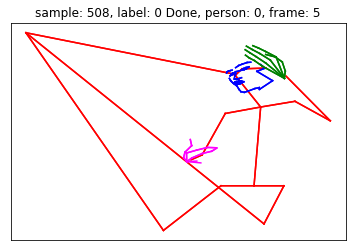

In [24]:
#lijst = [5, 15, 25, 35]
for sample in lijst:
    for e in range(len(train_samples[sample])):
        V_gif.visualize(train_samples[sample][e], sample, e)

In [25]:
for file in lijst:
    images = []
    new_path = 'gifs_gap_fixing/'
    if not os.path.isdir(new_path): #make new path
        os.mkdir(new_path)
    for filename in range(len(train_samples[file])):
        images.append(imageio.imread('plots/0/'+str(file)+'/'+str(filename)+'.png'))
    imageio.mimsave(new_path+str(file)+'.gif', images)
    

FileNotFoundError: No such file: 'C:\Users\main\Documents\ML_competition\plots\0\508\5.png'

In [ ]:
pose0 = all_samples[0][0]
pose1 = all_samples[0][1]
lengte = all_samples[519].shape[0]
print(lengte)
print(all_labels.shape[0])
print(all_samples[0].shape[0])
aantal_labels = 3718//18
lijst = []
som = 0
h_label = 0
for i in range(0, len(all_labels)): #aantal samples
    if all_labels[i] not in lijst:
        if (som > 20):
            som = 0
            h_label += 1
            lijst.append(all_labels[i])
            print("verhogen labels en toegevoegd")
        for e in range(all_samples[i].shape[0]): #aantal frames 
            V.visualize(all_samples[i][e], i, e, all_labels[i])
        som += 1
    

In [ ]:
import imageio
import os

print("imported")
paths = 'plots/'

aantal_labels = 3718//18
som = 0
h_label = 0
lijst = []
for file in range(0, all_labels.shape[0]):
    
    if (som > 20):
        som = 0
        h_label += 1
        print("verhogen labels")
    images = []
    new_path = 'gifs/'+str(all_labels[file + h_label*aantal_labels])+'/'
    if not os.path.isdir(new_path): #make new path
        os.mkdir(new_path)
    for filename in range(all_samples[file + h_label*aantal_labels].shape[0]):
        images.append(imageio.imread(new_path+str(file + h_label*aantal_labels)+'/'+str(filename)+'.png'))
    imageio.mimsave(new_path+str(file + h_label*aantal_labels)+'.gif', images)
    som += 1
print("done")

## Step 2: splitting the data set for validation and testing

Machine learning models easily overfit to the training data. The result of overfitting is that the model doesn't generalise well, i.e., the model performance on unseen data is considerably worse than on the training data. For this reason, it is important to try and make a decent estimation of the performance on unseen data by splitting off a test set that is **not used at all** for building the model. 

We make the distinction between **training** and **tuning the hyperparameters**. In, e.g. , linear regression or logistic regression, training means optimising the weights for a given combination of model and training data. The **hyperparameters** are parameters at a higher level than the weights: they include things like which features (and how many) are used, the regularisation parameter values, or generally anything that affects the model complexity. 

The best way to look at this is that each setting of hyperparameters corresponds to a different model and from all these possible settings, we want to pick the best or at least a decent one. Again, a 'good' model is a model that performs well on **unseen** data, so we need to select our best hyperparameters based on data we haven't used for training. However, as soon as data has been used for making **any** decision about the model, it is no longer unseen, so we always need to keep some dat apart for evaluation the final quality of our model. 

Tuning many hyperparameters can also lead to overfitting. If we choose hyperparameters based on the test data, the score on this part of the data will again not be representative anymore for the score on completely unseen data. Therefore, we can not do the hyperparameter selection based on the test data. This is why we need to split the remaining data a second time into a **training set** and a **validation set**. 

If your test set is too small, your estimate of the generalisation performance will not be reliable, if your validation set is too small, your selection of hyperparameters will be sub-optimal because it's based on an unreliable estimate, and if you make both of these large, you don't have enough data left to train your model. If you have a lot of data, relative to the task and model complexity, this is no problem. However, in most cases, you don't have that amount of data. This is the reason why we often use **cross-validation**: we split the data and optimise the model multiple times and average the model performance accross all runs to get a better estimate of the true validation score. Obviously, the amount of averaging you can afford greatly depends on the training time of each model and the computational resources you have at your disposal. In most cases, k-fold cross-validation is used. Here, the training data is split into k equal parts (called **folds**) and the model is trained k times, each time using a different part as the validation set. The cross-validation score is the average model performance accross all k trained models, each evaluated on their validation set. Once the optimal hyperparameters are chosen, the model is retrained with **all** training data and then tested on the test set.

In summary, the usual flow is:

- **Split off a test set:** don't look at this data except for the evaluation of your final model
- **Decide how many folds you need:** For large data sets, a single validation set is enough to give a decent estimate of the model error. However, for small data sets, the validation score can fluctuate a lot for different splits of the data, especially since we want to use as much data as possible for training, so validation sets will be small. For this reason, the same data set is often split multiple times into a train set and a validation set. For each **fold**, the model is trained and the validation error calculated. The best model parameters are chosen based on the average of the validation errors accross all the folds. One of the most common approaches is called **k-fold cross validation**. Here the dat is split into k equal (non-overlapping) parts and in each fold, a different part of the data is used for validation. 
- **Optimise the hyperparameters**
- **Train your final model:** Once the optimal hyperparameters are found, these can be fixed and a final model can be trained using all the original training data, i.e., all data that was previously used for training **or** validation. This is often forgotten!
- **Evaluate your final model:** use the test set you split off for evaluation. If you also need a more reliable test score (because you don't have enough data and have to keep your test set small), you can do nested cross validation by also considering multiple test sets, repeating the whole optimisation procedure for each test set and averaging the test scores. 

Although cross validation is well supported in sklearn and therefore sounds quite easy, this is also where many mistakes occur. In many real life situations, the data you have available for training is not really "i.i.d.". Instead, it comes from different subgroups, for instance, it may have been measured on different days or in different times of the year, originate from different test subjects, be collected by different enqueteurs, come from different customers or companies, ... and in most cases each of these subsets will have (hopefully slightly) different underlying distributions. Also, in most cases, you want your model to be robust against that, for instance, it should work with new patients or customers, or be useful to new companies. In that case, this is exactly what you need to evaluate during cross validation, by keeping entire subgroups within one fold and/or splitting off an entire subgroup in each test set. In addition, ideally, you are involved in the data collection: think about which differences may occur accross subgroups and really push having enough subgroups to allow your model to generalise beyond this. As we will see later in this course, the i.i.d. assumption also doesn't hold for time series. You can find more about cross-validation options on http://scikit-learn.org/stable/modules/cross_validation.html the sklearn documentation page.  

Now back to our cancer data set. In this case, we have no additional information about possible subgroups in the data (e.g., the data might have been collected in different labs, by different lab assistants, or with slightly different measurement equipment). Therefore, the best we can do is randomly splitting the data into train and test sets and use cross-validation with random folds.

In [ ]:
# Randomly split off a test set of approximatly 25% of the data

from sklearn.model_selection import train_test_split

test_fraction = 0.25
x_train, x_test, r_train, r_test = train_test_split(all_samples, all_labels, 
                                                    test_size = test_fraction, random_state=0)
print('split complete')

## Step 3: Training our first model

Now we are ready to build our first model using logistic regression. Note that you can repeat all the steps below for any model (linear or nonlinear) that is available in the sklearn library. 

Mind that the score that is reported here is **accuracy**, i.e., the fraction of the samples for which the correct class is predicted by the model. As seen in class, what is actually optimised by logistic regression is logloss and other classification models optimise other loss functions.

In [ ]:
# Import the model
from sklearn.linear_model import LogisticRegression

# Create a model instance 
# (this is a model object that can be trained, tuned and used)
# Note that we are using all the default settings here!

logreg0 = LogisticRegression(solver='liblinear')

# Train the model on the training data
for i in range(0, num_samples):
    logreg0.fit(x_train[i], r_train[i])
#logreg0.fit(x_train, r_train)

# step 4: predict labels for test data 

pred0 = logreg0.predict(x_test)

# step 4: calculate the accuracy of the model on the train set and on the test set

train_score0 = logreg0.score(x_train, r_train)
test_score0 = logreg0.score(x_test, r_test)

print("Accuracy of first model: ",train_score0," (train), ",test_score0," (test)")